# Trader Simulation in Mesa

I will attempt to build an identical model to mine in the Mesa framework. 

## Collision simulation
First I will attempt to build the collision simulation

### Initialising packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as constant
from scipy.optimize import curve_fit
import random
import math
import scipy.stats as stats
from tqdm.notebook import tqdm, trange
import ipywidgets as widgets
import mesa
import pandas as pd

### Writing new agent

In [67]:
class Trader(mesa.Agent):
    def __init__(self, unique_id, model, velocities = [1,1], m = 1, dimensions = 2):
        
        super().__init__(unique_id, model)
        self.dimensions = dimensions
        self._mass = m
        self._velocity = np.ones(self.dimensions)
        assert len(velocities) <= dimensions, 'Too few dimensions for provided input velocity array'
        
        for i, value in enumerate(velocities):
            self._velocity[i] = float(value)
            
        self._momentum = self._mass*self._velocity
        self.energy = 0.5*self._mass*np.linalg.norm(self._velocity)**2
        
        # Error handling
        assert dimensions > 0 and type(dimensions) == int, 'Must have positive integer dimensions'
        assert type(m) == int or type(m) == float, 'Mass must be numeric'
    

    @property
    def net_assets(self):
        return self._velocity[0] + self.commodity_value_intrinsic*self.commodities
    
    @property
    def velocity(self):
        return self._velocity
    
    @velocity.setter
    def velocity(self, value):
        # print("velocity setter method called")
        self._velocity = value
        self._momentum = self._mass*self._velocity
        self.energy = 0.5*self._mass*np.linalg.norm(self._velocity)**2

    @property
    def momentum(self):
        return self._momentum
    
    @momentum.setter
    def momentum(self, value):
        # print("setter method called")
        self._momentum = value
        self._velocity = self._momentum/self.mass
        self.energy = 0.5*self._mass*np.linalg.norm(self._velocity)**2
        
    @property
    def momentum_magnitude(self):
        return np.linalg.norm(self._momentum)
    
    @property
    def velocity_magnitude(self):
        return np.linalg.norm(self._velocity)

    def update(self):
        self._momentum = self._mass*self._velocity
        self.energy = 0.5*self._mass*np.linalg.norm(self._velocity)**2
    
    def step(self):
        other_traders = self.model.schedule.agents
        other = self.random.choice(other_traders)
        self.collision(other)
        
    def collision(self,other):
        
        # Momentum is conserved
        # mv + m'v' (before) = mv + m'v' (after)

        p_before = np.ones(self.dimensions)
        p_after = np.ones((self.dimensions,2))
        v_after = np.ones((self.dimensions,2))
        fractional_momentum_transfer = np.ones(self.dimensions)

        for i in range(self.dimensions):
            p_before[i] = self._mass*self.velocity[i] + other._mass*other.velocity[i]
            
            # randomise transfer of energy
            fractional_momentum_transfer[i] = np.random.random()
        
            p_after[i,0] = fractional_momentum_transfer[i]*p_before[i]
            p_after[i,1] = (1-fractional_momentum_transfer[i])*p_before[i]  
            
            v_after[i,0] = p_after[i,0]/self._mass
            v_after[i,1] = p_after[i,1]/self._mass
                     
            self._velocity[i] = v_after[i,0]
            other._velocity[i] = v_after[i,1]
            
            self.update()
            other.update()



# Rewriting Simulation class


In [68]:
class Simulation(mesa.Model):
    
    def __init__ (self,mean_collision_probability = 1, starting_velocity = 1,trader_mass = 2, no_traders = 10, sim_length=2, Dimensions = 2, collision_probability = 'all', collision_partner = 'random',collision_type = 'kinetic', collision_test = False, particle_history_test = False):
        self.no_traders = int(no_traders)
        self.simulation_length = int(sim_length)+1
        self.v0 = starting_velocity
        self.m = trader_mass
        self.dimensions = Dimensions
        self.mean_probability_of_collision = mean_collision_probability
        self.schedule = mesa.time.RandomActivation(self)

        self.type = collision_type
        self.collision_probability = collision_probability
        self.collision_partner = collision_partner
        self.collision_test = collision_test
        self.particle_history_test = particle_history_test

        
        self.init_traders()
        
    def init_traders(self):
        
        self.traders = []
        
        for i in range(self.no_traders):
            
            trader = Trader(i, self, velocities = np.full(self.dimensions, self.v0, dtype=float), m = 1, dimensions = self.dimensions)
            self.schedule.add(trader)
         
        self.datacollector = mesa.DataCollector(
            model_reporters = None, agent_reporters = {"Velocity": "velocity_magnitude"}
        )
        
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

        


In [74]:
sim = Simulation(no_traders = 1000)

for i in tqdm(range(100)):
    sim.step()        

  0%|          | 0/100 [00:00<?, ?it/s]

              Velocity
Step AgentID          
99   995      1.947207
     996      0.281603
     997      1.239037
     998      0.194548
     999      1.788880


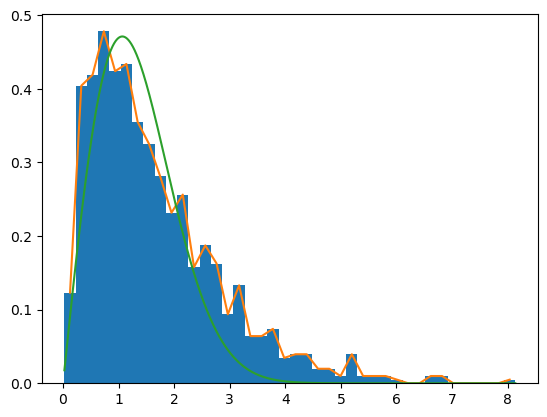

In [82]:
def Maxwell_Boltzmann_2D(v,v_offset = 0, alpha = 1, k = 1, l = 1):
    return k*2*alpha*(v-v_offset)*np.exp(-alpha*l*(v-v_offset)**2)

velocities = sim.datacollector.get_agent_vars_dataframe()
print(velocities.tail())
final_velocities = velocities.xs(99, level="Step")["Velocity"]
bin_heights, bin_edges, _ = plt.hist(final_velocities,bins = 40, density = True, stacked = True)
bin_centres = bin_edges[:-1] + np.diff(bin_edges)/2
plt.plot(bin_centres,bin_heights)
opt_params, pcov = curve_fit(Maxwell_Boltzmann_2D, bin_centres, bin_heights, p0=[1, 1, 1], bounds = (0,50))
perr = perr = np.sqrt(np.diag(pcov))
x_interval_for_fit = np.linspace(bin_edges[0], bin_edges[-1], 10000)
fit_y = Maxwell_Boltzmann_2D(x_interval_for_fit, *opt_params)
plt.plot(x_interval_for_fit, fit_y, label = 'f')

### Now want to try and make a real 2D simulation of particles in a box

Will use the mesa.continuous_space function

In [ ]:
class Trader(mesa.Agent):
    def __init__(self, unique_id, model, velocities = [1,1], m = 1, dimensions = 2):
        
        super().__init__(unique_id, model)
        self.dimensions = dimensions
        self._mass = m
        self._velocity = np.ones(self.dimensions)
        assert len(velocities) <= dimensions, 'Too few dimensions for provided input velocity array'
        
        for i, value in enumerate(velocities):
            self._velocity[i] = float(value)
            
        self._momentum = self._mass*self._velocity
        self.energy = 0.5*self._mass*np.linalg.norm(self._velocity)**2
        
        # Error handling
        assert dimensions > 0 and type(dimensions) == int, 'Must have positive integer dimensions'
        assert type(m) == int or type(m) == float, 'Mass must be numeric'
    

    @property
    def net_assets(self):
        return self._velocity[0] + self.commodity_value_intrinsic*self.commodities
    
    @property
    def velocity(self):
        return self._velocity
    
    @velocity.setter
    def velocity(self, value):
        # print("velocity setter method called")
        self._velocity = value
        self._momentum = self._mass*self._velocity
        self.energy = 0.5*self._mass*np.linalg.norm(self._velocity)**2

    @property
    def momentum(self):
        return self._momentum
    
    @momentum.setter
    def momentum(self, value):
        # print("setter method called")
        self._momentum = value
        self._velocity = self._momentum/self.mass
        self.energy = 0.5*self._mass*np.linalg.norm(self._velocity)**2
        
    @property
    def momentum_magnitude(self):
        return np.linalg.norm(self._momentum)
    
    @property
    def velocity_magnitude(self):
        return np.linalg.norm(self._velocity)

    def update(self):
        self._momentum = self._mass*self._velocity
        self.energy = 0.5*self._mass*np.linalg.norm(self._velocity)**2
    
    def move(self):
         
    
    def step(self):
        self.move()
        
        # other_traders = self.model.schedule.agents
        # other = self.random.choice(other_traders)
        # self.collision(other)
        
    def collision(self,other):
        
        # Momentum is conserved
        # mv + m'v' (before) = mv + m'v' (after)

        p_before = np.ones(self.dimensions)
        p_after = np.ones((self.dimensions,2))
        v_after = np.ones((self.dimensions,2))
        fractional_momentum_transfer = np.ones(self.dimensions)

        for i in range(self.dimensions):
            p_before[i] = self._mass*self.velocity[i] + other._mass*other.velocity[i]
            
            # randomise transfer of energy
            fractional_momentum_transfer[i] = np.random.random()
        
            p_after[i,0] = fractional_momentum_transfer[i]*p_before[i]
            p_after[i,1] = (1-fractional_momentum_transfer[i])*p_before[i]  
            
            v_after[i,0] = p_after[i,0]/self._mass
            v_after[i,1] = p_after[i,1]/self._mass
                     
            self._velocity[i] = v_after[i,0]
            other._velocity[i] = v_after[i,1]
            
            self.update()
            other.update()

